##non-used code

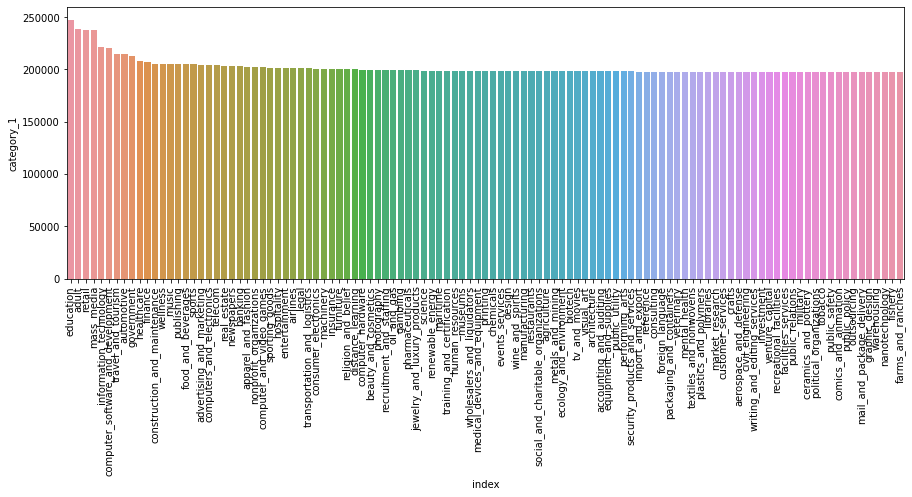

In [ ]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90 )
sns.barplot(data = sum(cad.category_2.value_counts(), cad.category_1.value_counts()).reset_index(), x =  'index', y = 'category_1') 

In [ ]:
c = df.groupby(['referrer_domain']).count()
cad = pd.merge(cad, c['timestamp'], left_on='domain', right_index=True)
cad.rename(columns = {'timestamp':'ref_dom_freq'}, inplace=True)
#how often this domain is refferal

c = df.groupby(['domain']).count()
cad = pd.merge(cad, c['timestamp'], left_on='domain', right_index=True)
cad.rename(columns = {'timestamp':'dom_freq', 'referrer_domain': 'has_ref_freq'}, inplace=True)
# domain frequency, 

c = df.groupby(['domain']).sum()
cad = pd.merge(cad, c['is_referrer'], left_on='domain', right_index=True)
cad.rename(columns = {'is_referrer':'has_referrer_freq'}, inplace=True)
# how often thus dom has reffer

# c = df.groupby(['referrer_domain']).sum()
# cad = pd.merge(cad, c['is_referrer'], left_on='domain', right_index=True)
# cad.rename(columns = {'is_referrer':'is_referrer_freq'}, inplace=True)
# how often thus dom has reffer

# c = df.groupby(['domain', 'referrer_domain']).count()
# cad = pd.merge(cad, c.event_group_id.reset_index(), on=['domain'],
#                right_index=True)#.rename(columns = {'event_group_id':'dom_ref_freq', 'timestamp_x_x':'timestamp'})
# cad


a = df.groupby(['domain']).count()[['referrer_domain', 'url']]
a['has_refferer_freq'] = a['referrer_domain'] / a['url']
df = pd.merge(df, a['has_refferer_freq'], left_on='domain', right_index = True)



c = df.groupby(['device_id', 'referrer_domain']).count()
df = pd.merge(df, c.timestamp, left_on=['device_id', 'domain'],
         right_index=True).rename(columns = {'timestamp_y':'dev_refdom_freq', 'timestamp_x':'timestamp'})
df
#how often this domain become refferal for this device 

a = [g for _, g in df.groupby(['device_id', 'event_group_id'])]

# a = df.groupby(['domain', 'referrer_domain']).count()
# df_ = pd.merge(df, a[['timestamp']], left_on=['domain', 'referrer_domain'], right_index= True, how='left' )\
#         .rename({'timestamp_y':'dom_refdom_count', 'timestamp_x': 'timestamp'}, axis=1, inplace=True)

## imports



In [16]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datetime import datetime
from operator import attrgetter


import pandas as pd
import numpy as np
import random

# import re
# import os

from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, OPTICS


# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, recall_score

## preprocessing 


In [46]:
df = pd.read_csv('/content/drive/MyDrive/notebooks/semrush /semrush_cup_train_data.csv')
cad = pd.read_csv('/content/drive/MyDrive/notebooks/semrush /semrush_cup_categories_and_demo.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/notebooks/semrush /semrush_cup_test_data.csv')

In [47]:
list_ = list(df['event_group_id'].unique()) 
a = int(np.round(len(list_)*0.8)/10)
random.shuffle(list_)
df_l = list_[:a] 
df = df.loc[df.event_group_id.isin(df_l)]


In [48]:
#  fill nan domains, drop urls (in version w nlp delete last 3 lines)
if df.domain.isna().sum()!= 0:
  df.domain.loc[df.domain.isna()] = df.loc[df.domain.isna()]\
                                      .apply(lambda x: x['url'].split('/')[0], axis = 1)\
                                      .apply(lambda x: '.'.join(x.split('.')[-2:]))

cad.drop(cad.loc[cad['domain'].isna()].index, inplace =True)

if df.loc[(df.referrer_domain.isna()) & (df.referrer_url.isna()==False)].shape[0] > 0:
  df.domain.loc[(df.referrer_domain.isna()) & (df.referrer_url.isna()==False)] = df.loc[(df.referrer_domain.isna()) & (df.referrer_url.isna()==False)]\
                                                                                    .apply(lambda x: x['referrer_url'].split('/')[0], axis = 1)\
                                                                                    .apply(lambda x: '.'.join(x.split('.')[-2:]))

if valid_df.domain.isna().sum() != 0:
  valid_df.domain.loc[valid_df.domain.isna()] = valid_df.loc[valid_df.domain.isna()]\
                                                        .apply(lambda x: x['url'].split('/')[0], axis = 1)\
                                                        .apply(lambda x: '.'.join(x.split('.')[-2:]))



# df.drop(['url', 'referrer_url'],  axis =1, inplace=True)
# valid_df.drop(['url'],  axis =1, inplace=True)
# cad['domain'] = cad['domain'].dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [49]:

cad = cad.loc[cad.domain.isna()==False]
valid_df = valid_df.loc[valid_df.domain.isna()==False]

df['nat_domain'] = df.domain.apply(lambda x: x.split('.')[-1])
df['nat_ref_domain'] = df.referrer_domain.dropna().apply(lambda x: x.split('.')[-1])

# cad['nat_domain'] = cad.domain.apply(lambda x: x.split('.')[-1])

valid_df['nat_domain'] = valid_df.domain.dropna().apply(lambda x: x.split('.')[-1])


In [50]:
# domains encoding & memory optimization

df['domain'].fillna('a', inplace = True)
df['referrer_domain'].fillna('a', inplace  = True)
df['domain'].fillna('a', inplace = True)

a = np.append(df['referrer_domain'].unique(), cad.domain.unique())
a = np.append(a , df['domain'].unique()) 
a = list(set(np.append(a , valid_df['domain'].unique())))

le = LabelEncoder()
le.fit(a)


df['domain'] = le.transform(df['domain'])
df['referrer_domain'] = le.transform(df['referrer_domain'])
cad['domain'] = le.transform(cad['domain'])
valid_df['domain']= le.transform(valid_df['domain'])


df['domain'] = df.domain.astype(int)
df['referrer_domain'] = df.referrer_domain.astype(int)
cad['domain'] = cad.domain.astype(int)
valid_df['domain'] = valid_df.domain.astype(int)




# nat domain encoding & memory optimization
a = list(set(np.append(df['nat_ref_domain'].unique() , df['nat_domain'].unique()))) 
a = list(set(np.append(a , valid_df['nat_domain'].unique())))
a.append('a')

le.fit(a)

df['nat_domain'] = le.transform(df['nat_domain'])
df['nat_ref_domain'] = le.transform(df['nat_ref_domain'].fillna('a'))
valid_df['nat_domain'] = le.transform(valid_df['nat_domain'])

df['nat_domain'] = df.nat_domain.astype(int)
df['nat_ref_domain'] = df.nat_ref_domain.astype(int)
valid_df['nat_domain'] = valid_df.nat_domain.astype(int)

del a 

# memory optimizatioin
df.replace({'target':11}, inplace = True)
valid_df.replace({'target':11}, inplace = True)

df['referrer_num'] = df.referrer_num.astype(int)
valid_df['referrer_num'] = valid_df.referrer_num.astype(int)


# categories encoding memory optimization
le.fit(np.append(cad['category_1'].unique(),  'a'))
cad['category_1'] = le.transform(cad['category_1'].fillna('a'))
cad['category_2'] = le.transform(cad['category_2'].fillna('a'))

In [51]:
cad.domain.isna().sum()

0

In [52]:
# remake w/o for loop
for i in cad.columns[3:]:
    cad[i].fillna(cad.groupby(['category_1', 'category_2'])[i].transform('median').dropna().round(2) , inplace= True)
    cad[i].fillna(cad.groupby(['category_2', 'category_1'])[i].transform('median').dropna().round(2), inplace= True)
    cad[i].fillna(cad.groupby('category_2')[i].transform('median').dropna().round(2), inplace= True)
    cad[i].fillna(cad.groupby('category_1')[i].transform('median').dropna().round(2), inplace= True)
# cad.fillna(cad.loc[(cad.category_1.isna()==True) & (cad.category_2.isna()==True)].mean().round(2), inplace= True)
cad[cad.columns[3:]].fillna(cad.median(), inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [53]:
c = df.groupby(['referrer_domain']).count()
df = pd.merge(df, c['timestamp'], left_on='domain', right_index=True, how='left')
df.rename(columns = {'timestamp_y':'ref_dom_freq', 'timestamp_x':'timestamp'}, inplace=True)
# # how often this domain is refferal for 
valid_df = pd.merge(valid_df, c['timestamp'], left_on='domain', right_index=True, how='left')
valid_df.rename(columns = {'timestamp_y':'ref_dom_freq', 'timestamp_x':'timestamp'}, inplace=True)
# # how often this domain is refferal for valid
df.ref_dom_freq.fillna(0, inplace = True)
valid_df.ref_dom_freq.fillna(0, inplace = True)

df['ref_dom_freq'] = df.ref_dom_freq.astype(int)
valid_df['ref_dom_freq'] = valid_df.ref_dom_freq.astype(int)


c = df.groupby(['domain']).count()
df = pd.merge(df, c['timestamp'], left_on='domain', right_index=True, how='left')
df.rename(columns = {'timestamp':'dom_freq', 'referrer_domain': 'has_ref_freq'}, inplace=True)
# # # domain frequency 
valid_df = pd.merge(valid_df, c['timestamp'], left_on='domain', right_index=True, how='left')
valid_df.rename(columns = {'timestamp_y':'dom_freq_', 'timestamp_x':'timestamp'}, inplace=True)
# # # domain frequency for val df
valid_df['dom_freq_'] = valid_df.dom_freq_.fillna(0).astype(int)

c = df.groupby(['referrer_domain']).sum()
df = pd.merge(df, c['is_referrer'], left_on='referrer_domain', right_index=True, how='left')
df.rename(columns = {'is_referrer_x':'is_referrer', 'is_referrer_y':'is_referrer_freq'}, inplace=True)
# # # # #is referrer freq  
# valid_df = pd.merge(valid_df, c['is_referrer'], left_on='domain', right_index=True, how='left')
# valid_df.rename(columns = {'timestamp_y':'ref_dom_freq', 'timestamp_x':'timestamp'}, inplace=True)
# # # # # is referrer count  for val df 


In [54]:
# def del_empty(a):
#     return len(list(filter(lambda x: x!= '', a )))
# # returns len of clean list

def timestamp_to_tuple(ts):
    attrs = ('year', 'month', 'day', 'hour')#, 'minute', 'second')
    d_tuple = attrgetter(*attrs)(datetime.fromtimestamp(ts))
    return d_tuple

df['datetime'] = df.timestamp.apply(timestamp_to_tuple)
df['month'] = df.datetime.apply(lambda x: x[1])
df['day'] = df.datetime.apply(lambda x: x[2])
df['hour'] = df.datetime.apply(lambda x: x[3])

df.drop(columns = ['datetime', 'timestamp'], inplace = True)

valid_df['datetime'] = valid_df.timestamp.apply(timestamp_to_tuple)
valid_df['month'] = valid_df.datetime.apply(lambda x: x[1])
valid_df['day'] = valid_df.datetime.apply(lambda x: x[2])
valid_df['hour'] = valid_df.datetime.apply(lambda x: x[3])

valid_df.drop(columns = ['datetime', 'timestamp'], inplace = True)


In [55]:
df.to_csv('/content/drive/MyDrive/notebooks/semrush /df_pp.csv')
valid_df.to_csv('/content/drive/MyDrive/notebooks/semrush /valid_pp.csv')
cad.to_csv('/content/drive/MyDrive/notebooks/semrush /cad_pp.csv')


## train test


In [45]:
df = pd.read_csv('/content/drive/MyDrive/notebooks/semrush /df_pp.csv', index_col=[0] )
# valid_df = pd.read_csv('/content/drive/MyDrive/notebooks/semrush /valid_pp.csv', index_col=[0] )
cad =  pd.read_csv('/content/drive/MyDrive/notebooks/semrush /cad_pp.csv', index_col=[0] )




In [46]:
cad['dom_freq'] =  cad.dom_freq.fillna(0).astype(int)
cad['category_1'] =  cad.category_1.fillna(0).astype(int)
cad['category_2'] =  cad.category_2.fillna(0).astype(int)

In [47]:
df = pd.merge(df, cad , on = 'domain', how= 'left')
# valid_df = pd.merge(valid_df, cad , on = 'domain', how= 'left')
del cad

df.loc[df.M.isna()] = df.loc[df.M.isna()].fillna(df.median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [48]:
df.drop(columns = ['referrer_url', 'url'], inplace = True)

In [49]:
# traintest split shuffled aprox same distribution on large data
list_ = list(df['event_group_id'].unique()) 
a = int(np.round(len(list_)*0.8)) # len of  list of event ids  for tr/t split

random.shuffle(list_)

train = list_[:a] 
test = list_[a:]
# list of shuffled event ids


train = df.loc[df.event_group_id.isin(train)]
test = df.loc[df.event_group_id.isin(test)]
del df, list_

In [50]:
predict  = test[['event_group_id', 'is_referrer']].copy()

In [51]:
x_test =  test.drop(['is_referrer' ], axis =1)
y_test = test['is_referrer']
del test 

x_train = train.drop('is_referrer', axis =1)
y_train = train['is_referrer']
del train

# x_valid =  valid_df.copy()
# del valid_df

In [61]:
x_train['category_1'] = x_train.category_1.astype(int)
x_train['category_2'] = x_train.category_2.astype(int)

x_test['category_1'] = x_test.category_1.astype(int)
x_test['category_2'] = x_test.category_2.astype(int)

In [63]:
# list(x_train.columns)
# cat_cols = ['event_group_id',
#             'device_id','domain',
#             'referrer_domain','referrer_num',
#             'month','day', 'hour',
#             'nat_domain', 'nat_ref_domain',
#             'category_1', 'category_2']
# text_cols = ['category_1', 'category_2']

cat_cols = ['event_group_id', 'device_id', 'domain', 'referrer_domain',
            'referrer_num', 'nat_domain', 'nat_ref_domain',
            'month', 'day', 'hour', 'category_1', 'category_2']

In [ ]:
model = CatBoostClassifier(cat_features=cat_cols)
model.fit(x_train, y_train)


In [70]:
preds_prob = model.predict_proba(x_test)
predict['preds_proba'] = preds_prob[::, 1]

In [71]:
true_values = predict.groupby('event_group_id').apply(lambda x: x['is_referrer'].argmax()).values
predict_values = predict.groupby('event_group_id').apply(lambda x: x['preds_proba'].argmax()).values

In [72]:
f1_score(true_values, predict_values, average='macro')

0.40465749460558803

In [73]:
precision_score(true_values, predict_values, average='macro')

0.4169506046426216

In [74]:
recall_score(true_values, predict_values, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3944694158072941